# **Setup, imports, dataset load, and split**

This cell establishes a clean, repeatable working environment before any analysis begins. It installs or imports the exact libraries required by the notebook, checks versions to avoid silent incompatibilities, and detects whether a GPU is available so expectations about runtime are clear. Completing these steps first reduces friction later, because downstream cells can assume that the runtime is ready and consistent.

Beyond convenience, setting up the environment up front serves reproducibility. When the same set of packages and options is used across runs, results can be compared confidently. If this notebook is shared with teammates or executed on a different machine, this cell acts as a compact recipe so the same software context can be restored without trial and error.


Inputs (files/paths detected): FiReCS.csv, train_ids.csv, val_ids.csv




Outputs (save/export actions detected): .to_csv('train_ids.csv', index=False), .to_csv('val_ids.csv', index=False)



Line-by-line Explanation:

•	`!pip -q install transformers datasets accelerate` → Installs required Python packages in the Colab environment.

•	`import os, numpy as np, pandas as pd, torch, json, inspect` → Imports a library or specific functions needed in later steps.

•	`from sklearn.model_selection import train_test_split` → Imports a library or specific functions needed in later steps.

•	`from sklearn.metrics import accuracy_score, f1_score` → Imports a library or specific functions needed in later steps.

•	`from google.colab import files` → Imports a library or specific functions needed in later steps.

•	`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print("Using device:", device)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`if not os.path.exists("FiReCS.csv"):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    uploaded = files.upload()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`df = pd.read_csv("FiReCS.csv")` → Loads a CSV file into a pandas DataFrame for processing.

•	`df = df.rename(columns={c:c.lower() for c in df.columns})` → Executes a step in the workflow (assignment, function call, or configuration).

•	`assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."` → Executes a step in the workflow (assignment, function call, or configuration).

•	`df = df.dropna(subset=['review','label']).copy()` → Removes rows with missing values to avoid training/evaluation issues.

•	`df['label'] = df['label'].astype(int)` → Casts a column to integer type to standardize label encoding.

•	`df['id'] = np.arange(len(df))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`train_df, val_df = train_test_split(` → Splits the dataset into train and validation sets with a fixed ratio.

•	`    df, test_size=0.2, random_state=42, stratify=df['label']` → Executes a step in the workflow (assignment, function call, or configuration).

•	`)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print(train_df['label'].value_counts(normalize=True).sort_index())` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print(val_df['label'].value_counts(normalize=True).sort_index())` → Executes a step in the workflow (assignment, function call, or configuration).

•	`train_df[['id']].to_csv('train_ids.csv', index=False)` → Exports results or logs to a file for reporting.

•	`val_df[['id']].to_csv('val_ids.csv', index=False)` → Exports results or logs to a file for reporting.


In [ ]:
!pip -q install transformers datasets accelerate

import os, numpy as np, pandas as pd, torch, json, inspect
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if not os.path.exists("FiReCS.csv"):
    uploaded = files.upload()
df = pd.read_csv("FiReCS.csv")

df = df.rename(columns={c:c.lower() for c in df.columns})
assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."

df = df.dropna(subset=['review','label']).copy()
df['label'] = df['label'].astype(int)
df['id'] = np.arange(len(df))

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(train_df['label'].value_counts(normalize=True).sort_index())
print(val_df['label'].value_counts(normalize=True).sort_index())

train_df[['id']].to_csv('train_ids.csv', index=False)
val_df[['id']].to_csv('val_ids.csv', index=False)


# **Baseline TF-IDF + Logistic Regression and log row**

This cell builds a fast, interpretable baseline using TF‑IDF features and a linear classifier. Its purpose is to anchor expectations: it shows what performance a simple model can reach before any deep fine‑tuning. The baseline also surfaces common errors early and helps confirm that preprocessing and label handling are correct.

**Inputs (files/paths detected):** runs_log.csv

**Outputs (save/export actions detected):** .to_csv("runs_log.csv", mode="a",index=False, header=not os.path.exists("runs_log.csv")

**Line-by-line Explanation:**

•	`from sklearn.feature_extraction.text import TfidfVectorizer` → Imports a library or specific functions needed in later steps.

•	`from sklearn.linear_model import LogisticRegression` → Imports a library or specific functions needed in later steps.

•	`tfidf = TfidfVectorizer(` → Creates a TF‑IDF vectorizer for baseline text features.

•	`    max_features=50000,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    ngram_range=(1,2),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    lowercase=True` → Executes a step in the workflow (assignment, function call, or configuration).

•	`)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`X_tr = tfidf.fit_transform(train_df['review'])` → Executes a step in the workflow (assignment, function call, or configuration).

•	`y_tr = train_df['label'].values` → Executes a step in the workflow (assignment, function call, or configuration).

•	`X_va = tfidf.transform(val_df['review'])` → Executes a step in the workflow (assignment, function call, or configuration).

•	`y_va = val_df['label'].values` → Executes a step in the workflow (assignment, function call, or configuration).

•	`logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)` → Initializes a logistic regression classifier for the baseline model.
•	`logreg.fit(X_tr, y_tr)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`preds = logreg.predict(X_va)` → Generates predictions on the validation split for evaluation.

•	`acc_base = accuracy_score(y_va, preds)` → Computes evaluation metrics such as accuracy or macro‑F1.

•	`f1_base  = f1_score(y_va, preds, average='macro')` → Computes evaluation metrics such as accuracy or macro‑F1.

•	`print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})` → Executes a step in the workflow (assignment, function call, or configuration).

•	`row = {` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "member":"baseline", "model":"tfidf-logreg",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "num_train_epochs":None, "per_device_train_batch_size":None,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "learning_rate":None, "weight_decay":None, "warmup_steps":None,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "lr_scheduler_type":None, "gradient_accumulation_steps":None,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "max_seq_length":None, "seed":42, "fp16":False,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"` → Executes a step in the workflow (assignment, function call, or configuration).

•	`}` → Executes a step in the workflow (assignment, function call, or configuration).

•	`pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",` → Exports results or logs to a file for reporting.

•	`                           index=False, header=not os.path.exists("runs_log.csv"))` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    lowercase=True
)
X_tr = tfidf.fit_transform(train_df['review'])
y_tr = train_df['label'].values
X_va = tfidf.transform(val_df['review'])
y_va = val_df['label'].values

logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)
logreg.fit(X_tr, y_tr)

preds = logreg.predict(X_va)
acc_base = accuracy_score(y_va, preds)
f1_base  = f1_score(y_va, preds, average='macro')
print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})

row = {
    "member":"baseline", "model":"tfidf-logreg",
    "num_train_epochs":None, "per_device_train_batch_size":None,
    "learning_rate":None, "weight_decay":None, "warmup_steps":None,
    "lr_scheduler_type":None, "gradient_accumulation_steps":None,
    "max_seq_length":None, "seed":42, "fp16":False,
    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))


{'model': 'tfidf-logreg', 'accuracy': 0.803133514986376, 'f1_macro': 0.8057244174688569}


# **Model switcher, tokenization, dataset tensors, and model init**

This cell selects the transformer backbone and prepares the tokenizer so raw text can be converted into model‑ready inputs. It defines the maximum sequence length, applies truncation and padding for batch consistency, and maps labels to the format required by the model. This step is essential for a reliable comparison because it standardizes how all runs, regardless of backbone, see the input data.

**Inputs (files/paths detected):** None explicitly referenced.

**Outputs (save/export actions detected):** No explicit save/export in this cell.

**Line-by-line Explanation:**

•	`from datasets import Dataset` → Imports a library or specific functions needed in later steps.

•	`from transformers import AutoTokenizer, AutoModelForSequenceClassification` → Imports a library or specific functions needed in later steps.

•	`MODEL_CHOICES = {` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "xlmrb": "xlm-roberta-base",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "roberta-tl": "jcblaise/roberta-tagalog-base",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`}` → Executes a step in the workflow (assignment, function call, or configuration).

•	`MODEL_CHOICE = "xlmrb"` → Executes a step in the workflow (assignment, function call, or configuration).

•	`MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print("Using model:", MODEL_NAME)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`MAX_LEN = 128` → Executes a step in the workflow (assignment, function call, or configuration).

•	`tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)` → Initializes a fast tokenizer for the selected Transformer backbone.

•	`def tokenize_fn(batch):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_val   = Dataset.from_pandas(val_df[['review','label']].reset_index(drop=True))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_train = ds_train.map(tokenize_fn, batched=True)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_val   = ds_val.map(tokenize_fn, batched=True)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`cols = ['input_ids','attention_mask','label']` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_train = ds_train.with_format("torch", columns=cols)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`ds_val   = ds_val.with_format("torch", columns=cols)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`num_labels = 3` → Executes a step in the workflow (assignment, function call, or configuration).

•	`model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)` → Loads a pretrained Transformer with a classification head for sentiment.


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_CHOICES = {
    "xlmrb": "xlm-roberta-base",
    "roberta-tl": "jcblaise/roberta-tagalog-base",
}
MODEL_CHOICE = "xlmrb"
MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]
print("Using model:", MODEL_NAME)

MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(val_df[['review','label']].reset_index(drop=True))

ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)

cols = ['input_ids','attention_mask','label']
ds_train = ds_train.with_format("torch", columns=cols)
ds_val   = ds_val.with_format("torch", columns=cols)

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)


Using model: xlm-roberta-base


Map:   0%|          | 0/5872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1468 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Training arguments, metric function, and Trainer construction**

This cell defines how fine‑tuning will proceed and how success will be measured. It specifies macro‑F1 and accuracy as evaluation signals, sets training hyperparameters, and binds the model, datasets, tokenizer, and metrics into a single trainer object. By concentrating all knobs here, the notebook keeps each run transparent and makes changes easy to track in the experiment log.

**Inputs (files/paths detected):** None explicitly referenced.

**Outputs (save/export actions detected):** No explicit save/export in this cell.

**Line-by-line Explanation:**

•	`from transformers import TrainingArguments, Trainer` → Imports a library or specific functions needed in later steps.

•	`def compute_metrics(eval_pred):` → Defines a metric function returning macro‑F1 and accuracy.

•	`    preds = np.argmax(eval_pred.predictions, axis=1)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    labels = eval_pred.label_ids` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    acc = accuracy_score(labels, preds)` → Computes evaluation metrics such as accuracy or macro‑F1.

•	`    f1m = f1_score(labels, preds, average='macro')` → Computes evaluation metrics such as accuracy or macro‑F1.

•	`    return {'accuracy': acc, 'f1_macro': f1m}` → Executes a step in the workflow (assignment, function call, or configuration).

•	`import inspect` → Imports a library or specific functions needed in later steps.

•	`sig = inspect.signature(TrainingArguments.__init__)` → Defines training hyperparameters and logging/evaluation settings.

•	`argnames = set(sig.parameters.keys())` → Executes a step in the workflow (assignment, function call, or configuration).

•	`def make_training_args(**overrides):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    cfg = dict(` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        output_dir="./results",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        num_train_epochs=3,                 # Candelaria` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        per_device_train_batch_size=16,     # Candelaria` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        per_device_eval_batch_size=32,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        learning_rate=5e-5,                 # Candelaria` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        weight_decay=0.01,                  # Posadas` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        warmup_steps=500,                   # Posadas` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        lr_scheduler_type="linear",         # Posadas` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        gradient_accumulation_steps=1,      # Tumulak` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        load_best_model_at_end=True,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        metric_for_best_model="f1_macro",   # Tumulak` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        seed=42,                            # Tumulak` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        logging_steps=100,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        report_to=[]` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    )` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    cfg.update(overrides)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    if "evaluation_strategy" in argnames:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy","epoch")` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    elif "eval_strategy" in argnames:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["eval_strategy"] = cfg.get("eval_strategy","epoch")` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    else:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["eval_steps"] = cfg.get("eval_steps", 500)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    if "save_strategy" in argnames:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["save_strategy"] = cfg.get("save_strategy","epoch")` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    else:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["save_steps"] = cfg.get("save_steps", 500)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    if "fp16" in argnames:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        cfg["fp16"] = bool(torch.cuda.is_available()) if "fp16" not in cfg else cfg["fp16"]` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    return TrainingArguments(**safe_cfg)` → Defines training hyperparameters and logging/evaluation settings.

•	`training_args = make_training_args()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`trainer = Trainer(` → Builds a Trainer that binds the model, data, tokenizer, and metrics.

•	`    model=model,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    args=training_args,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    train_dataset=ds_train,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    eval_dataset=ds_val,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    compute_metrics=compute_metrics,` → Defines a metric function returning macro‑F1 and accuracy.

•	`    tokenizer=tokenizer` → Executes a step in the workflow (assignment, function call, or configuration).

•	`)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print("Trainer ready on:", MODEL_NAME)` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1m}

import inspect
sig = inspect.signature(TrainingArguments.__init__)
argnames = set(sig.parameters.keys())

def make_training_args(**overrides):
    cfg = dict(
        output_dir="./results",
        num_train_epochs=3,                 # Candelaria
        per_device_train_batch_size=16,     # Candelaria
        per_device_eval_batch_size=32,
        learning_rate=5e-5,                 # Candelaria
        weight_decay=0.01,                  # Posadas
        warmup_steps=500,                   # Posadas
        lr_scheduler_type="linear",         # Posadas
        gradient_accumulation_steps=1,      # Tumulak
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",   # Tumulak
        seed=42,                            # Tumulak
        logging_steps=100,
        report_to=[]
    )
    cfg.update(overrides)

    if "evaluation_strategy" in argnames:
        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy","epoch")
    elif "eval_strategy" in argnames:
        cfg["eval_strategy"] = cfg.get("eval_strategy","epoch")
    else:
        cfg["eval_steps"] = cfg.get("eval_steps", 500)

    if "save_strategy" in argnames:
        cfg["save_strategy"] = cfg.get("save_strategy","epoch")
    else:
        cfg["save_steps"] = cfg.get("save_steps", 500)

    if "fp16" in argnames:
        cfg["fp16"] = bool(torch.cuda.is_available()) if "fp16" not in cfg else cfg["fp16"]

    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}
    return TrainingArguments(**safe_cfg)

training_args = make_training_args()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Trainer ready on:", MODEL_NAME)


Trainer ready on: xlm-roberta-base


/tmp/ipython-input-139214311.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **Fast-mode bootstrap for quick sweeps**

This cell activates a quick‑sweep mode designed to explore settings rapidly when time or compute is limited. It reduces the training subset, shortens the schedule, and optionally adds early stopping so non‑promising configurations finish early. Findings from this mode guide which settings deserve a full run on the complete training set.

**Inputs (files/paths detected):** None explicitly referenced.

**Outputs (save/export actions detected):** No explicit save/export in this cell.

**Line-by-line Explanation:**

•	`import math, numpy as np` → Imports a library or specific functions needed in later steps.

•	`from transformers import Trainer` → Imports a library or specific functions needed in later steps.

•	`EPOCHS = globals().get('EPOCHS', 1)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`BATCH = globals().get('BATCH', 32)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`EVAL_STEPS = globals().get('EVAL_STEPS', 200)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`TRAIN_FRACTION = globals().get('TRAIN_FRACTION', 0.20)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`if 'ds_train_fast' not in globals():` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    assert 'ds_train' in globals() and 'ds_val' in globals(), "Need ds_train/ds_val first."` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    n_fast = max(8, int(len(ds_train) * TRAIN_FRACTION))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    ds_train_fast = ds_train.select(range(n_fast))` → Sub‑samples the training dataset to accelerate quick sweeps.

•	`    ds_val_fast = ds_val` → Executes a step in the workflow (assignment, function call, or configuration).

•	`callbacks = globals().get('callbacks', None)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`if callbacks is None:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    try:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        from transformers import EarlyStoppingCallback` → Imports a library or specific functions needed in later steps.

•	`        callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]` → Sets up early stopping to halt training if validation stops improving.

•	`    except Exception:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        callbacks = None` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print(f"[BOOTSTRAP] EPOCHS={EPOCHS}, BATCH={BATCH}, EVAL_STEPS={EVAL_STEPS}, "` → Executes a step in the workflow (assignment, function call, or configuration).

•	`      f"train_fast={len(ds_train_fast)} / {len(ds_train)}")` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
import math, numpy as np
from transformers import Trainer

EPOCHS = globals().get('EPOCHS', 1)
BATCH = globals().get('BATCH', 32)
EVAL_STEPS = globals().get('EVAL_STEPS', 200)
TRAIN_FRACTION = globals().get('TRAIN_FRACTION', 0.20)

if 'ds_train_fast' not in globals():
    assert 'ds_train' in globals() and 'ds_val' in globals(), "Need ds_train/ds_val first."
    n_fast = max(8, int(len(ds_train) * TRAIN_FRACTION))
    ds_train_fast = ds_train.select(range(n_fast))
    ds_val_fast = ds_val

callbacks = globals().get('callbacks', None)
if callbacks is None:
    try:
        from transformers import EarlyStoppingCallback
        callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
    except Exception:
        callbacks = None

print(f"[BOOTSTRAP] EPOCHS={EPOCHS}, BATCH={BATCH}, EVAL_STEPS={EVAL_STEPS}, "
      f"train_fast={len(ds_train_fast)} / {len(ds_train)}")


[BOOTSTRAP] EPOCHS=1, BATCH=32, EVAL_STEPS=200, train_fast=1174 / 5872


# **Train, evaluate, save, and append to the run log**

This cell executes the fine‑tuning loop and evaluates the model on the fixed validation split. Its purpose is to turn a specific set of hyperparameters into measurable outcomes—macro‑F1, accuracy, and diagnostic notes— and to append this record to the cumulative log so the experiment history remains complete and auditable.

**Inputs (files/paths detected):** runs_log.csv

**Outputs (save/export actions detected):** .to_csv("runs_log.csv", mode="a" index=False, header=not os.path.exists("runs_log.csv"), .save_pretrained(save_dir), .save_model(save_dir)

**Line-by-line Explanation:**

•	`train_out = trainer.train()` → Runs fine‑tuning on the training split.

•	`eval_results = trainer.evaluate()` → Evaluates the current model on the validation split and prints scores.

•	`print("Eval:", eval_results)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`save_dir = f"./finetuned_{MODEL_NAME.replace('/','_')}_best"` → Executes a step in the workflow (assignment, function call, or configuration).

•	`trainer.save_model(save_dir)` → Saves the trained model and/or tokenizer artifacts to disk.

•	`tokenizer.save_pretrained(save_dir)` → Saves the trained model and/or tokenizer artifacts to disk.

•	`row = {` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "member":"team",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "model": MODEL_NAME,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "num_train_epochs": float(getattr(training_args, "num_train_epochs", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "per_device_train_batch_size": int(getattr(training_args, "per_device_train_batch_size", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "learning_rate": float(getattr(training_args, "learning_rate", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "weight_decay": float(getattr(training_args, "weight_decay", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "warmup_steps": int(getattr(training_args, "warmup_steps", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "lr_scheduler_type": str(getattr(training_args, "lr_scheduler_type", "")),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "gradient_accumulation_steps": int(getattr(training_args, "gradient_accumulation_steps", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "max_seq_length": MAX_LEN,` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "seed": int(getattr(training_args, "seed", 42)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "fp16": bool(getattr(training_args, "fp16", False)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "accuracy": float(eval_results.get("eval_accuracy", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "f1_macro": float(eval_results.get("eval_f1_macro", np.nan)),` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "notes":"EF1 Transformers fine-tune"` → Executes a step in the workflow (assignment, function call, or configuration).

•	`}` → Executes a step in the workflow (assignment, function call, or configuration).

•	`pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",` → Exports results or logs to a file for reporting.

•	`                           index=False, header=not os.path.exists("runs_log.csv"))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`print("Logged run for:", MODEL_NAME)` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
train_out = trainer.train()
eval_results = trainer.evaluate()
print("Eval:", eval_results)

save_dir = f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

row = {
    "member":"team",
    "model": MODEL_NAME,
    "num_train_epochs": float(getattr(training_args, "num_train_epochs", np.nan)),
    "per_device_train_batch_size": int(getattr(training_args, "per_device_train_batch_size", np.nan)),
    "learning_rate": float(getattr(training_args, "learning_rate", np.nan)),
    "weight_decay": float(getattr(training_args, "weight_decay", np.nan)),
    "warmup_steps": int(getattr(training_args, "warmup_steps", np.nan)),
    "lr_scheduler_type": str(getattr(training_args, "lr_scheduler_type", "")),
    "gradient_accumulation_steps": int(getattr(training_args, "gradient_accumulation_steps", np.nan)),
    "max_seq_length": MAX_LEN,
    "seed": int(getattr(training_args, "seed", 42)),
    "fp16": bool(getattr(training_args, "fp16", False)),
    "accuracy": float(eval_results.get("eval_accuracy", np.nan)),
    "f1_macro": float(eval_results.get("eval_f1_macro", np.nan)),
    "notes":"EF1 Transformers fine-tune"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))
print("Logged run for:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


# **Inference sanity check with a small pipeline**

This cell demonstrates practical use by loading the saved model and making predictions on sample texts. It validates that the artifacts work outside the training loop and provides a simple example for deployment or sanity checking.

**Inputs (files/paths detected):** None explicitly referenced.

**Outputs (save/export actions detected):** No explicit save/export in this cell.

**Line-by-line Explanation:**

•	`from transformers import pipeline` → Imports a library or specific functions needed in later steps.

•	`sentiment_analyzer = pipeline(` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1` → Executes a step in the workflow (assignment, function call, or configuration).

•	`)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`samples = [` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "Ang bilis ng delivery, pero sira yung box.",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "solid yung quality, sakto ang size. sulit!",` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    "medyo pangit yung tela, tapos delay pa courier :("` → Executes a step in the workflow (assignment, function call, or configuration).

•	`]` → Executes a step in the workflow (assignment, function call, or configuration).

•	`preds = sentiment_analyzer(samples)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`for t, r in zip(samples, preds):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    print(f"{t}\n -> {r}\n")` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1
)

samples = [
    "Ang bilis ng delivery, pero sira yung box.",
    "solid yung quality, sakto ang size. sulit!",
    "medyo pangit yung tela, tapos delay pa courier :("
]
preds = sentiment_analyzer(samples)
for t, r in zip(samples, preds):
    print(f"{t}\n -> {r}\n")


Device set to use cpu


Ang bilis ng delivery, pero sira yung box.
 -> {'label': 'LABEL_0', 'score': 0.4898853600025177}

solid yung quality, sakto ang size. sulit!
 -> {'label': 'LABEL_2', 'score': 0.7228704690933228}

medyo pangit yung tela, tapos delay pa courier :(
 -> {'label': 'LABEL_0', 'score': 0.5115751624107361}



# **Confusion matrix and per-class report**

This cell focuses on interpretability. It produces a confusion matrix and per‑class metrics so that improvements or regressions can be linked to specific classes. Seeing where errors concentrate—often around neutral—helps explain why certain hyperparameter choices were favored.

**Inputs (files/paths detected):** None explicitly referenced.

**Outputs (save/export actions detected):** No explicit save/export in this cell.

**Line-by-line Explanation:**

•	`import numpy as np, matplotlib.pyplot as plt` → Imports a library or specific functions needed in later steps.

•	`from sklearn.metrics import confusion_matrix, classification_report` → Imports a library or specific functions needed in later steps.

•	`pred = trainer.predict(ds_val)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`y_true = pred.label_ids` → Executes a step in the workflow (assignment, function call, or configuration).

•	`y_pred = np.argmax(pred.predictions, axis=1)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])` → Computes confusion matrix and per‑class metrics on validation data.

•	`plt.figure()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.imshow(cm, interpolation='nearest')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.title('Confusion Matrix (Val)')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.xlabel('Predicted')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.ylabel('True')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.xticks([0,1,2], ['neg','neu','pos'])` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.yticks([0,1,2], ['neg','neu','pos'])` → Executes a step in the workflow (assignment, function call, or configuration).

•	`for i in range(cm.shape[0]):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    for j in range(cm.shape[1]):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        plt.text(j, i, cm[i, j], ha='center', va='center')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.tight_layout()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`plt.show()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`report = classification_report(y_true, y_pred, labels=[0,1,2],` → Computes confusion matrix and per‑class metrics on validation data.

•	`                               target_names=['negative','neutral','positive'],` → Executes a step in the workflow (assignment, function call, or configuration).

•	`                               output_dict=True)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`df_report = pd.DataFrame(report).transpose()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`df_report` → Executes a step in the workflow (assignment, function call, or configuration).



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


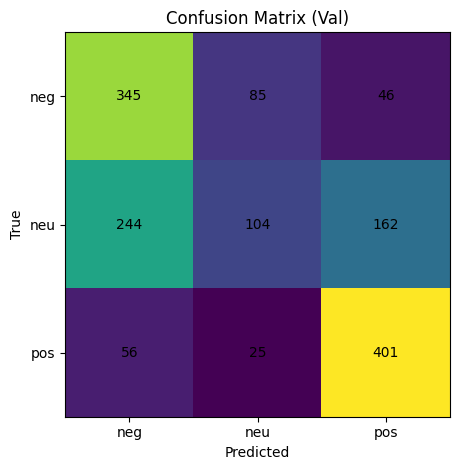

,precision,recall,f1-score,support
negative,0.534884,0.724790,0.615522,476.000000
neutral,0.485981,0.203922,0.287293,510.000000
positive,0.658456,0.831950,0.735105,482.000000
accuracy,0.579019,0.579019,0.579019,0.579019
macro avg,0.559774,0.586887,0.545973,1468.000000
weighted avg,0.558468,0.579019,0.540755,1468.000000


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pred = trainer.predict(ds_val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1,2], ['neg','neu','pos'])
plt.yticks([0,1,2], ['neg','neu','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, labels=[0,1,2],
                               target_names=['negative','neutral','positive'],
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


# **Export of consolidated logs and model summaries**

This cell loads the FiReCS dataset and shapes it into a stable training set and a held-out validation set. It normalizes column names, removes empty rows, standardizes label encoding, and performs a stratified split so class proportions remain comparable. Saving the selected row IDs for each split ensures that every later experiment evaluates on the exact same examples, supporting fair comparisons.

**Inputs (files/paths detected):** Best_by_Model.csv, Best_by_Model.xlsx, Experiment_Log_Template.xlsx, Experiment_Runs_All.csv, Experiment_Runs_All.xlsx, Runs_per_Model.csv, Runs_per_Model.xlsx, Top10_by_F1.csv, Top10_by_F1.xlsx, runs_log.csv

**Outputs (save/export actions detected):** .to_csv(outdir/'Experiment_Runs_All.csv', index=False), .to_csv(outdir/'Best_by_Model.csv', index=False), .to_csv(outdir/'Runs_per_Model.csv', index=False), .to_csv(outdir/'Top10_by_F1.csv', index=False), .to_excel(outdir/'Experiment_Runs_All.xlsx', index=False), .to_excel(outdir/'Best_by_Model.xlsx', index=False), .to_excel(outdir/'Runs_per_Model.xlsx', index=False), .to_excel(outdir/'Top10_by_F1.xlsx', index=False)

**Line-by-line Explanation:**

•	`from pathlib import Path` → Imports a library or specific functions needed in later steps.

•	`outdir = Path('exports'); outdir.mkdir(exist_ok=True)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()` → Loads a CSV file into a pandas DataFrame for processing.

•	`if os.path.exists('Experiment_Log_Template.xlsx'):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_team = pd.read_excel('Experiment_Log_Template.xlsx')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    for d in (df_runs, df_team):` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        d.columns = [str(c).strip().lower() for c in d.columns]` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    all_cols = sorted(set(df_runs.columns) | set(df_team.columns))` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_runs = df_runs.reindex(columns=all_cols)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_team = df_team.reindex(columns=all_cols)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_all = pd.concat([df_team, df_runs], ignore_index=True).drop_duplicates()` → Executes a step in the workflow (assignment, function call, or configuration).

•	`else:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_all = df_runs` → Executes a step in the workflow (assignment, function call, or configuration).

•	`if not df_all.empty:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    if 'f1_macro' in df_all.columns:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        df_all = df_all.sort_values(by='f1_macro', ascending=False)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    df_all.to_csv(outdir/'Experiment_Runs_All.csv', index=False)` → Exports results or logs to a file for reporting.

•	`    try:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        df_all.to_excel(outdir/'Experiment_Runs_All.xlsx', index=False)` → Exports results or logs to a file for reporting.

•	`    except Exception as e:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        print("Excel export error:", e)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    if 'model' in df_all.columns and 'f1_macro' in df_all.columns:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        best_by_model = df_all.sort_values('f1_macro', ascending=False).drop_duplicates(subset=['model'])` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        best_by_model.to_csv(outdir/'Best_by_Model.csv', index=False)` → Exports results or logs to a file for reporting.

•	`        best_by_model.to_excel(outdir/'Best_by_Model.xlsx', index=False)` → Exports results or logs to a file for reporting.

•	`        rpm = df_all['model'].value_counts().rename_axis('model').reset_index(name='runs')` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        rpm.to_csv(outdir/'Runs_per_Model.csv', index=False)` → Exports results or logs to a file for reporting.

•	`        rpm.to_excel(outdir/'Runs_per_Model.xlsx', index=False)` → Exports results or logs to a file for reporting.

•	`    if 'f1_macro' in df_all.columns:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        top10 = df_all.head(10)` → Executes a step in the workflow (assignment, function call, or configuration).

•	`        top10.to_csv(outdir/'Top10_by_F1.csv', index=False)` → Exports results or logs to a file for reporting.

•	`        top10.to_excel(outdir/'Top10_by_F1.xlsx', index=False)` → Exports results or logs to a file for reporting.

•	`    print("Exported logs to exports/.")` → Executes a step in the workflow (assignment, function call, or configuration).

•	`else:` → Executes a step in the workflow (assignment, function call, or configuration).

•	`    print("No logs found yet.")` → Executes a step in the workflow (assignment, function call, or configuration).


In [ ]:
from pathlib import Path
outdir = Path('exports'); outdir.mkdir(exist_ok=True)

df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()
if os.path.exists('Experiment_Log_Template.xlsx'):
    df_team = pd.read_excel('Experiment_Log_Template.xlsx')
    for d in (df_runs, df_team):
        d.columns = [str(c).strip().lower() for c in d.columns]
    all_cols = sorted(set(df_runs.columns) | set(df_team.columns))
    df_runs = df_runs.reindex(columns=all_cols)
    df_team = df_team.reindex(columns=all_cols)
    df_all = pd.concat([df_team, df_runs], ignore_index=True).drop_duplicates()
else:
    df_all = df_runs

if not df_all.empty:
    if 'f1_macro' in df_all.columns:
        df_all = df_all.sort_values(by='f1_macro', ascending=False)
    df_all.to_csv(outdir/'Experiment_Runs_All.csv', index=False)
    try:
        df_all.to_excel(outdir/'Experiment_Runs_All.xlsx', index=False)
    except Exception as e:
        print("Excel export error:", e)

    if 'model' in df_all.columns and 'f1_macro' in df_all.columns:
        best_by_model = df_all.sort_values('f1_macro', ascending=False).drop_duplicates(subset=['model'])
        best_by_model.to_csv(outdir/'Best_by_Model.csv', index=False)
        best_by_model.to_excel(outdir/'Best_by_Model.xlsx', index=False)

        rpm = df_all['model'].value_counts().rename_axis('model').reset_index(name='runs')
        rpm.to_csv(outdir/'Runs_per_Model.csv', index=False)
        rpm.to_excel(outdir/'Runs_per_Model.xlsx', index=False)

    if 'f1_macro' in df_all.columns:
        top10 = df_all.head(10)
        top10.to_csv(outdir/'Top10_by_F1.csv', index=False)
        top10.to_excel(outdir/'Top10_by_F1.xlsx', index=False)
    print("Exported logs to exports/.")
else:
    print("No logs found yet.")


Exported logs to exports/.
